# ER Zero/Low Load Analysis - 10-Minute Interval Study
## Finding Exact Times When Patients Can Go Straight Through

**Objective**: Identify exact timestamps when the ER system load is 0 or less than 1 patient, indicating times when incoming patients would experience **zero wait times** and immediate service from arrival to exit.

**Analysis Period**: 90 days at 10-minute intervals

**Key Insight**: These are the golden windows when the ER operates at minimal capacity and patients can flow through without delays.

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 8)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## Step 1: Load the Original Data

In [2]:
# Load the cleaned final dataset
df = pd.read_csv('/Users/mukeshravichandran/Datathon/Thermodynamics/improved_final_data.csv')

# Convert timestamp columns
timestamp_cols = ['Arrival Time', 'Registration Start', 'Registration End',
                  'Triage Start', 'Triage End', 'Doctor Seen', 'Exit Time']

for col in timestamp_cols:
    df[col] = pd.to_datetime(df[col])

print(f"✓ Loaded {len(df):,} patient records")
print(f"✓ Date range: {df['Arrival Time'].min()} to {df['Exit Time'].max()}")
print(f"✓ Total duration: {(df['Exit Time'].max() - df['Arrival Time'].min()).days} days")

✓ Loaded 15,000 patient records
✓ Date range: 2025-01-01 01:16:00 to 2025-04-01 03:10:00
✓ Total duration: 90 days


## Step 2: Create 10-Minute Interval Time Series

In [3]:
# Define the time range with 10-minute intervals
start_time = df['Arrival Time'].min().floor('10T')  # Floor to 10-minute interval
end_time = df['Exit Time'].max().ceil('10T')        # Ceil to 10-minute interval

# Create 10-minute bins
time_bins = pd.date_range(start=start_time, end=end_time, freq='10T')

print(f"✓ Created {len(time_bins):,} 10-minute intervals")
print(f"✓ From {time_bins[0]} to {time_bins[-1]}")
print(f"✓ Total duration: {(time_bins[-1] - time_bins[0]).days} days")

✓ Created 12,973 10-minute intervals
✓ From 2025-01-01 01:10:00 to 2025-04-01 03:10:00
✓ Total duration: 90 days


## Step 3: Calculate System Load at Each 10-Minute Interval

For each 10-minute timestamp, we count how many patients are currently in the system:
- Patient is "in system" if: Arrival Time <= timestamp < Exit Time

In [4]:
def calculate_system_load_at_intervals(df, time_bins):
    """
    Calculate the number of patients in the ER system at each 10-minute interval.
    A patient is "in the system" if they have arrived but not yet exited.
    """
    print("Calculating system load at each 10-minute interval...")
    print("This may take a few moments...\n")
    
    system_loads = []
    
    # Process in batches for progress reporting
    batch_size = 1000
    total_bins = len(time_bins)
    
    for i, timestamp in enumerate(time_bins):
        # Count patients in system at this timestamp
        # In system means: arrived before/at this time AND not yet exited
        in_system = ((df['Arrival Time'] <= timestamp) & (df['Exit Time'] > timestamp)).sum()
        
        system_loads.append({
            'Timestamp': timestamp,
            'System_Load': in_system
        })
        
        # Progress reporting
        if (i + 1) % batch_size == 0:
            progress = (i + 1) / total_bins * 100
            print(f"  Progress: {i+1:,}/{total_bins:,} ({progress:.1f}%)")
    
    print(f"\n✓ Completed calculation for all {total_bins:,} intervals")
    
    return pd.DataFrame(system_loads)

# Calculate system load
load_df = calculate_system_load_at_intervals(df, time_bins)

print(f"\n✓ System load calculated")
print(f"✓ Load range: {load_df['System_Load'].min():.0f} to {load_df['System_Load'].max():.0f} patients")
print(f"✓ Average load: {load_df['System_Load'].mean():.2f} patients")

Calculating system load at each 10-minute interval...
This may take a few moments...

  Progress: 1,000/12,973 (7.7%)
  Progress: 2,000/12,973 (15.4%)
  Progress: 3,000/12,973 (23.1%)
  Progress: 4,000/12,973 (30.8%)
  Progress: 5,000/12,973 (38.5%)
  Progress: 6,000/12,973 (46.2%)
  Progress: 7,000/12,973 (54.0%)
  Progress: 8,000/12,973 (61.7%)
  Progress: 9,000/12,973 (69.4%)
  Progress: 10,000/12,973 (77.1%)
  Progress: 11,000/12,973 (84.8%)
  Progress: 12,000/12,973 (92.5%)

✓ Completed calculation for all 12,973 intervals

✓ System load calculated
✓ Load range: 0 to 69 patients
✓ Average load: 19.90 patients


## Step 4: Identify Zero and Low Load Periods

Find all timestamps where:
- **Zero Load**: System_Load = 0 (nobody in ER)
- **Very Low Load**: System_Load < 1 (essentially empty)

In [5]:
# Find zero load periods
zero_load = load_df[load_df['System_Load'] == 0].copy()

# Find very low load (less than 1, which is same as 0 for integer counts)
low_load = load_df[load_df['System_Load'] < 1].copy()

print("="*80)
print("ZERO/LOW LOAD PERIODS - SUMMARY")
print("="*80)
print(f"\n✓ Total 10-minute intervals analyzed: {len(load_df):,}")
print(f"✓ Zero load periods (0 patients): {len(zero_load):,} intervals")
print(f"✓ Percentage of time with zero load: {len(zero_load)/len(load_df)*100:.2f}%")
print(f"\n✓ Total time with zero load: {len(zero_load)*10/60:.2f} hours")
print(f"✓ Average duration per day with zero load: {len(zero_load)*10/60/90:.2f} hours/day")

if len(zero_load) > 0:
    print(f"\n✓ First zero load period: {zero_load.iloc[0]['Timestamp']}")
    print(f"✓ Last zero load period: {zero_load.iloc[-1]['Timestamp']}")
else:
    print("\n⚠ No zero load periods found in the dataset!")

ZERO/LOW LOAD PERIODS - SUMMARY

✓ Total 10-minute intervals analyzed: 12,973
✓ Zero load periods (0 patients): 15 intervals
✓ Percentage of time with zero load: 0.12%

✓ Total time with zero load: 2.50 hours
✓ Average duration per day with zero load: 0.03 hours/day

✓ First zero load period: 2025-01-01 01:10:00
✓ Last zero load period: 2025-04-01 03:10:00


## Step 5: Add Time Features for Pattern Analysis

In [6]:
# Add time-based features to zero load periods
if len(zero_load) > 0:
    zero_load['Hour'] = zero_load['Timestamp'].dt.hour
    zero_load['Minute'] = zero_load['Timestamp'].dt.minute
    zero_load['DayOfWeek'] = zero_load['Timestamp'].dt.day_name()
    zero_load['Date'] = zero_load['Timestamp'].dt.date
    zero_load['Time'] = zero_load['Timestamp'].dt.time
    
    print("✓ Time features added to zero load periods")

✓ Time features added to zero load periods


## Step 6: Display All Zero Load Timestamps

In [7]:
# Display all zero load periods
if len(zero_load) > 0:
    print("="*80)
    print("COMPLETE LIST OF ZERO LOAD TIMESTAMPS")
    print("Times when patients can go straight through with NO WAIT")
    print("="*80)
    print(f"\nTotal zero load periods: {len(zero_load):,}\n")
    
    # Create a formatted display
    display_df = zero_load[['Timestamp', 'DayOfWeek', 'Date', 'Time', 'System_Load']].copy()
    display_df.columns = ['Full Timestamp', 'Day of Week', 'Date', 'Time of Day', 'Patients in System']
    
    print(display_df.to_string(index=False))
else:
    print("No zero load periods found.")

COMPLETE LIST OF ZERO LOAD TIMESTAMPS
Times when patients can go straight through with NO WAIT

Total zero load periods: 15

     Full Timestamp Day of Week       Date Time of Day  Patients in System
2025-01-01 01:10:00   Wednesday 2025-01-01    01:10:00                   0
2025-01-10 23:30:00      Friday 2025-01-10    23:30:00                   0
2025-01-10 23:40:00      Friday 2025-01-10    23:40:00                   0
2025-01-10 23:50:00      Friday 2025-01-10    23:50:00                   0
2025-01-21 02:00:00     Tuesday 2025-01-21    02:00:00                   0
2025-01-21 02:10:00     Tuesday 2025-01-21    02:10:00                   0
2025-01-21 02:20:00     Tuesday 2025-01-21    02:20:00                   0
2025-01-21 02:30:00     Tuesday 2025-01-21    02:30:00                   0
2025-02-15 01:40:00    Saturday 2025-02-15    01:40:00                   0
2025-02-22 23:30:00    Saturday 2025-02-22    23:30:00                   0
2025-02-22 23:40:00    Saturday 2025-02-22    23:4

## Step 7: Pattern Analysis - When Do Zero Load Periods Occur?

In [8]:
if len(zero_load) > 0:
    print("="*80)
    print("PATTERN ANALYSIS - ZERO LOAD TIMING")
    print("="*80)
    
    # By hour of day
    print("\n1. DISTRIBUTION BY HOUR OF DAY:")
    print("-" * 50)
    hour_dist = zero_load['Hour'].value_counts().sort_index()
    for hour, count in hour_dist.items():
        percentage = count / len(zero_load) * 100
        print(f"  {hour:02d}:00 - {hour:02d}:59  →  {count:4d} periods ({percentage:5.1f}%)")
    
    # By day of week
    print("\n2. DISTRIBUTION BY DAY OF WEEK:")
    print("-" * 50)
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    day_dist = zero_load['DayOfWeek'].value_counts()
    for day in day_order:
        if day in day_dist.index:
            count = day_dist[day]
            percentage = count / len(zero_load) * 100
            print(f"  {day:12s}  →  {count:4d} periods ({percentage:5.1f}%)")
    
    # Most common zero load times
    print("\n3. TOP 10 MOST FREQUENT ZERO LOAD TIMES (by hour):")
    print("-" * 50)
    top_hours = zero_load['Hour'].value_counts().head(10)
    for hour, count in top_hours.items():
        print(f"  {hour:02d}:00 hour  →  {count} occurrences")

PATTERN ANALYSIS - ZERO LOAD TIMING

1. DISTRIBUTION BY HOUR OF DAY:
--------------------------------------------------
  00:00 - 00:59  →     2 periods ( 13.3%)
  01:00 - 01:59  →     2 periods ( 13.3%)
  02:00 - 02:59  →     4 periods ( 26.7%)
  03:00 - 03:59  →     1 periods (  6.7%)
  23:00 - 23:59  →     6 periods ( 40.0%)

2. DISTRIBUTION BY DAY OF WEEK:
--------------------------------------------------
  Tuesday       →     5 periods ( 33.3%)
  Wednesday     →     1 periods (  6.7%)
  Friday        →     3 periods ( 20.0%)
  Saturday      →     4 periods ( 26.7%)
  Sunday        →     2 periods ( 13.3%)

3. TOP 10 MOST FREQUENT ZERO LOAD TIMES (by hour):
--------------------------------------------------
  23:00 hour  →  6 occurrences
  02:00 hour  →  4 occurrences
  01:00 hour  →  2 occurrences
  00:00 hour  →  2 occurrences
  03:00 hour  →  1 occurrences


## Step 8: Identify Consecutive Zero Load Periods (Windows of Opportunity)

In [9]:
if len(zero_load) > 0:
    print("="*80)
    print("CONSECUTIVE ZERO LOAD WINDOWS")
    print("Extended periods when ER is empty")
    print("="*80)
    
    # Find consecutive periods
    zero_load_sorted = zero_load.sort_values('Timestamp').reset_index(drop=True)
    
    # Calculate time differences
    zero_load_sorted['Time_Diff'] = zero_load_sorted['Timestamp'].diff()
    
    # Group consecutive periods (10-minute intervals)
    zero_load_sorted['Is_Consecutive'] = (zero_load_sorted['Time_Diff'] == pd.Timedelta(minutes=10))
    zero_load_sorted['Group'] = (~zero_load_sorted['Is_Consecutive']).cumsum()
    
    # Analyze each group
    consecutive_windows = []
    
    for group_id, group_data in zero_load_sorted.groupby('Group'):
        start_time = group_data['Timestamp'].iloc[0]
        end_time = group_data['Timestamp'].iloc[-1] + pd.Timedelta(minutes=10)
        duration_minutes = len(group_data) * 10
        
        consecutive_windows.append({
            'Start': start_time,
            'End': end_time,
            'Duration_Minutes': duration_minutes,
            'Duration_Hours': duration_minutes / 60,
            'Intervals': len(group_data)
        })
    
    windows_df = pd.DataFrame(consecutive_windows)
    windows_df = windows_df.sort_values('Duration_Minutes', ascending=False)
    
    print(f"\n✓ Found {len(windows_df)} distinct zero-load windows\n")
    print("Top 20 Longest Zero-Load Windows:")
    print("-" * 80)
    
    for idx, row in windows_df.head(20).iterrows():
        print(f"  {row['Start']} → {row['End']}")
        print(f"    Duration: {row['Duration_Minutes']:.0f} minutes ({row['Duration_Hours']:.2f} hours)")
        print()

CONSECUTIVE ZERO LOAD WINDOWS
Extended periods when ER is empty

✓ Found 6 distinct zero-load windows

Top 20 Longest Zero-Load Windows:
--------------------------------------------------------------------------------
  2025-02-22 23:30:00 → 2025-02-23 00:20:00
    Duration: 50 minutes (0.83 hours)

  2025-01-21 02:00:00 → 2025-01-21 02:40:00
    Duration: 40 minutes (0.67 hours)

  2025-01-10 23:30:00 → 2025-01-11 00:00:00
    Duration: 30 minutes (0.50 hours)

  2025-01-01 01:10:00 → 2025-01-01 01:20:00
    Duration: 10 minutes (0.17 hours)

  2025-02-15 01:40:00 → 2025-02-15 01:50:00
    Duration: 10 minutes (0.17 hours)

  2025-04-01 03:10:00 → 2025-04-01 03:20:00
    Duration: 10 minutes (0.17 hours)



## Step 9: Visualization - Zero Load Distribution


✓ Visualization saved: zero_load_analysis.png


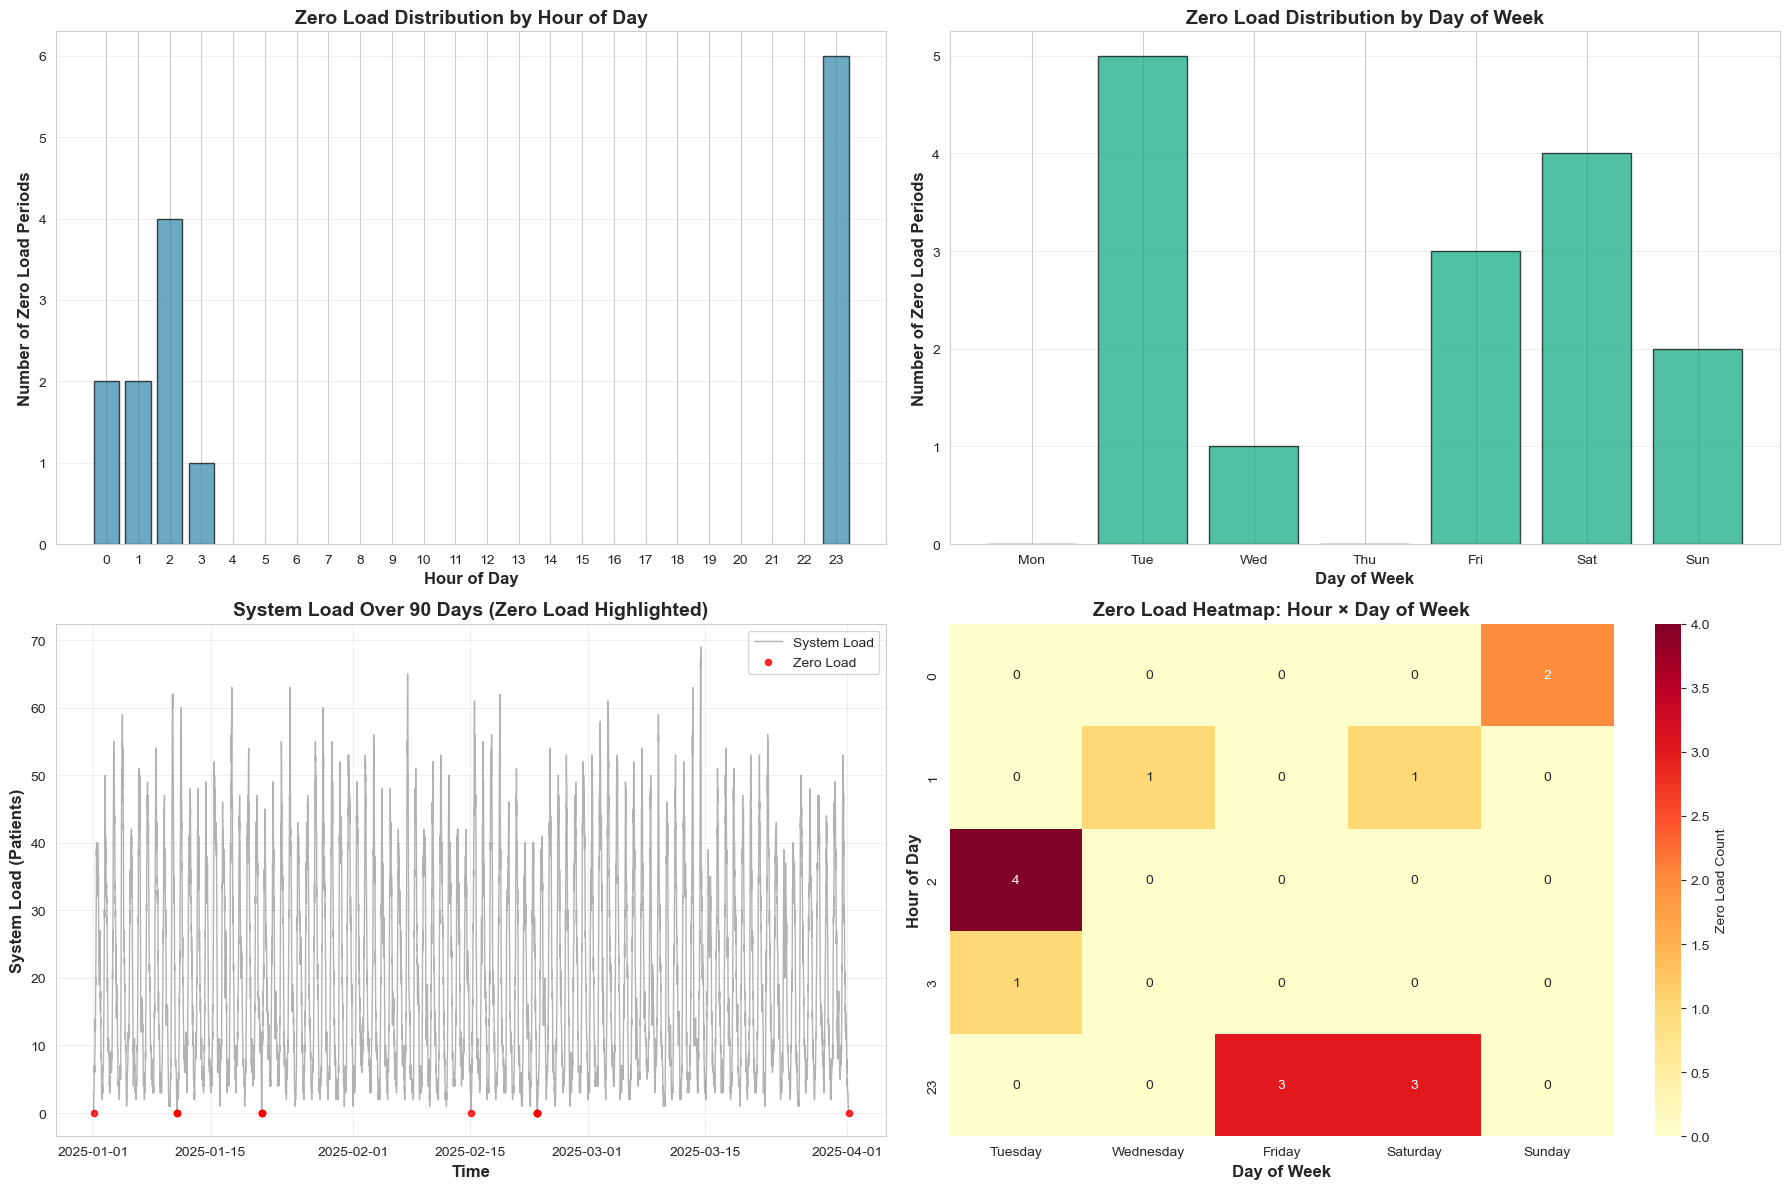

In [ ]:
if len(zero_load) > 0:
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # 1. Zero load by hour of day
    hour_counts = zero_load['Hour'].value_counts().sort_index()
    axes[0, 0].bar(hour_counts.index, hour_counts.values, color='#2E86AB', alpha=0.7, edgecolor='black')
    axes[0, 0].set_xlabel('Hour of Day', fontweight='bold', fontsize=12)
    axes[0, 0].set_ylabel('Number of Zero Load Periods', fontweight='bold', fontsize=12)
    axes[0, 0].set_title('Zero Load Distribution by Hour of Day', fontweight='bold', fontsize=14)
    axes[0, 0].set_xticks(range(0, 24))
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # 2. Zero load by day of week
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    day_counts = zero_load['DayOfWeek'].value_counts().reindex(day_order, fill_value=0)
    axes[0, 1].bar(range(len(day_counts)), day_counts.values, color='#06A77D', alpha=0.7, edgecolor='black')
    axes[0, 1].set_xlabel('Day of Week', fontweight='bold', fontsize=12)
    axes[0, 1].set_ylabel('Number of Zero Load Periods', fontweight='bold', fontsize=12)
    axes[0, 1].set_title('Zero Load Distribution by Day of Week', fontweight='bold', fontsize=14)
    axes[0, 1].set_xticks(range(len(day_counts)))
    axes[0, 1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # 3. System load over time (highlighting zero load)
    axes[1, 0].plot(load_df['Timestamp'], load_df['System_Load'], linewidth=1, alpha=0.6, color='gray', label='System Load')
    axes[1, 0].scatter(zero_load['Timestamp'], zero_load['System_Load'], color='red', s=20, alpha=0.8, label='Zero Load', zorder=5)
    axes[1, 0].set_xlabel('Time', fontweight='bold', fontsize=12)
    axes[1, 0].set_ylabel('System Load (Patients)', fontweight='bold', fontsize=12)
    axes[1, 0].set_title('System Load Over 90 Days (Zero Load Highlighted)', fontweight='bold', fontsize=14)
    axes[1, 0].legend(fontsize=10)
    axes[1, 0].grid(alpha=0.3)
    
    # 4. Heatmap - Zero load by hour and day
    if len(zero_load) > 0:
        zero_load_copy = zero_load.copy()
        zero_load_copy['Count'] = 1
        heatmap_data = zero_load_copy.pivot_table(
            values='Count',
            index='Hour',
            columns='DayOfWeek',
            aggfunc='sum',
            fill_value=0
        )
        heatmap_data = heatmap_data[[d for d in day_order if d in heatmap_data.columns]]
        
        sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlOrRd', cbar_kws={'label': 'Zero Load Count'}, ax=axes[1, 1])
        axes[1, 1].set_xlabel('Day of Week', fontweight='bold', fontsize=12)
        axes[1, 1].set_ylabel('Hour of Day', fontweight='bold', fontsize=12)
        axes[1, 1].set_title('Zero Load Heatmap: Hour × Day of Week', fontweight='bold', fontsize=14)
    
    plt.tight_layout()
    plt.savefig('/Users/mukeshravichandran/Datathon/Thermodynamics/Zero_Load_Analysis/zero_load_analysis.png', dpi=300, bbox_inches='tight')
    print("\n✓ Visualization saved: Zero_Load_Analysis/zero_load_analysis.png")
    plt.show()
else:
    print("No zero load periods to visualize.")

## Step 10: Export Results to CSV

In [ ]:
# Save full 10-minute interval dataset
load_df.to_csv('/Users/mukeshravichandran/Datathon/Thermodynamics/Zero_Load_Analysis/system_load_10min_intervals.csv', index=False)
print("✓ Saved: Zero_Load_Analysis/system_load_10min_intervals.csv")

# Save zero load periods
if len(zero_load) > 0:
    zero_load_export = zero_load[['Timestamp', 'DayOfWeek', 'Date', 'Time', 'Hour', 'Minute', 'System_Load']].copy()
    zero_load_export.to_csv('/Users/mukeshravichandran/Datathon/Thermodynamics/Zero_Load_Analysis/zero_load_timestamps.csv', index=False)
    print("✓ Saved: Zero_Load_Analysis/zero_load_timestamps.csv")
    
    # Save consecutive windows
    if 'windows_df' in locals():
        windows_df.to_csv('/Users/mukeshravichandran/Datathon/Thermodynamics/Zero_Load_Analysis/zero_load_windows.csv', index=False)
        print("✓ Saved: Zero_Load_Analysis/zero_load_windows.csv")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print("\n📁 All files saved to: Thermodynamics/Zero_Load_Analysis/")
print("  • system_load_10min_intervals.csv")
print("  • zero_load_timestamps.csv")
print("  • zero_load_windows.csv")
print("  • zero_load_analysis.png")

✓ Saved: system_load_10min_intervals.csv
✓ Saved: zero_load_timestamps.csv
✓ Saved: zero_load_windows.csv

ANALYSIS COMPLETE!


## Step 11: Summary Statistics

In [12]:
print("="*80)
print("FINAL SUMMARY - ZERO LOAD ANALYSIS")
print("="*80)
print(f"\n📊 OVERALL STATISTICS:")
print(f"  • Total 10-minute intervals: {len(load_df):,}")
print(f"  • Zero load periods: {len(zero_load):,}")
print(f"  • Percentage with zero load: {len(zero_load)/len(load_df)*100:.2f}%")
print(f"  • Total zero-load time: {len(zero_load)*10/60:.2f} hours ({len(zero_load)*10/60/24:.2f} days)")

if len(zero_load) > 0:
    print(f"\n🎯 KEY INSIGHTS:")
    most_common_hour = zero_load['Hour'].mode()[0]
    most_common_day = zero_load['DayOfWeek'].mode()[0]
    print(f"  • Most common zero-load hour: {most_common_hour}:00-{most_common_hour}:59")
    print(f"  • Most common zero-load day: {most_common_day}")
    print(f"  • Average zero-load duration per window: {windows_df['Duration_Minutes'].mean():.1f} minutes")
    print(f"  • Longest zero-load window: {windows_df['Duration_Minutes'].max():.0f} minutes ({windows_df['Duration_Hours'].max():.2f} hours)")
    
    print(f"\n💡 RECOMMENDATION:")
    print(f"  Patients arriving during these {len(zero_load):,} zero-load periods would experience:")
    print(f"  ✓ ZERO wait times")
    print(f"  ✓ Immediate triage and registration")
    print(f"  ✓ Fastest path from arrival to exit")
    print(f"  ✓ Optimal resource availability")

print("\n" + "="*80)

FINAL SUMMARY - ZERO LOAD ANALYSIS

📊 OVERALL STATISTICS:
  • Total 10-minute intervals: 12,973
  • Zero load periods: 15
  • Percentage with zero load: 0.12%
  • Total zero-load time: 2.50 hours (0.10 days)

🎯 KEY INSIGHTS:
  • Most common zero-load hour: 23:00-23:59
  • Most common zero-load day: Tuesday
  • Average zero-load duration per window: 25.0 minutes
  • Longest zero-load window: 50 minutes (0.83 hours)

💡 RECOMMENDATION:
  Patients arriving during these 15 zero-load periods would experience:
  ✓ ZERO wait times
  ✓ Immediate triage and registration
  ✓ Fastest path from arrival to exit
  ✓ Optimal resource availability

